In [1]:
import torch
import numpy as np
import pyvista as pv
import Ofpp
from utils.visualizer import *
pv.set_jupyter_backend('static') 

import sys
import os
sys.path.insert(0, r'C:\Users\Noahc\Documents\USYD\PHD\8 - Github\Torch_VFM')
from src.utils.mesh_utils import *
from src.utils.data_utils import get_bc_dict
from src.gauss_green import gaus_green_vfm_mesh
from src.physics.operators import *

dtype = torch.float32

In [2]:
def load_case_mesh(dir, bc_dict):
    vtk_file_reader = pv.POpenFOAMReader(dir)

    # Get Mesh
    mesh = gaus_green_vfm_mesh(vtk_file_reader, dtype = dtype, bc_dict=bc_dict)
    # if bc_dict is not None:
    #     mesh.add_bc_conditions(bc_dict)

    # Get Ground Truth Data
    vtk_file_reader.set_active_time_value(vtk_file_reader.time_values[-1])
    vtk_file_reader.cell_to_point_creation = False
    vtk_file_reader.enable_all_patch_arrays()
    vtk_mesh = vtk_file_reader.read()[0]
    try:
        U_gt = torch.tensor(vtk_mesh['U'], dtype = dtype).unsqueeze(0).unsqueeze(0)
    except:
        print('Error fetching U from mesh, setting to None')
        U_gt = None
    return mesh, vtk_mesh, U_gt

## Cavity Case Validation
- Orthogonal with no Skew
- Solved Purely linear, with no corrections

In [3]:
U_bc_dict = {
            'movingWall':{ "type":'fixedValue', "value":[1,0,0]},
            'fixedWalls':{ "type":'noSlip'},  
            'frontAndBack':{ "type":'empty'}    
            }
p_bc_dict = {
    'movingWall':{ "type":'zeroGradient' },
    'fixedWalls':{ "type":'zeroGradient' },  
    'frontAndBack':{ "type":'empty'}    
}
bc_dict = {'U':U_bc_dict, 'p':p_bc_dict}

nu = 0.0001
L = 0.1

In [4]:
dataset = np.load(r'C:\Users\Noahc\Documents\USYD\PHD\0 - Work Space\Geneva_FVM_results\cavity_hybrid_training_analysis\steady_cavity_case_b200_maxU100ms_simple_normalized.npy')
dataset.shape

(200, 256, 256, 3)

In [6]:
nu = 0.01
lid_v = np.arange(5, 1005, 5)
np.linspace(1, 1001, 200)
mom_pred = []
for i in range(dataset.shape[0]):
    sample_u = torch.tensor(dataset[i,...,:2],dtype=dtype).reshape(-1,2).unsqueeze(0).unsqueeze(0)
    sample_u = torch.nn.functional.pad(sample_u, (0, 1))
    sample_p = torch.tensor(dataset[i,...,-1],dtype=dtype).reshape(-1,1).unsqueeze(0).unsqueeze(0)
    Re = lid_v[i]

    _, gradp_pred = Divergence_Operator.caclulate(mesh, field=sample_p, field_type='p')
    divU_pred, gradU_pred = Divergence_Operator.caclulate(mesh, field=sample_u)
    lap_pred = Laplacian_Operator.caclulate(mesh, field=sample_u)

    mom_pred.append(divU_pred - (1/Re)*lap_pred + gradp_pred)

mom_pred = torch.cat(mom_pred, dim=0)
print(mom_pred.shape)

torch.Size([200, 1, 65536, 3])


In [7]:
mom_pred2 = mom_pred.reshape(200,256,256,3)[:,2:-2,2:-2,:]
mom_pred2 = mom_pred2.reshape(200,int(252*252),3)

In [8]:
mom_pred2.shape

torch.Size([200, 63504, 3])

In [ ]:
#target = torch.log1p((torch.tensor(lid_v[:,None,None,None])*mom_pred)**2)
#target = torch.log1p((torch.tensor(lid_v[:,None,None,None])*mom_pred2)**2)
#target = mom_pred**2

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 30481920000 bytes.

<function matplotlib.pyplot.show(close=None, block=None)>

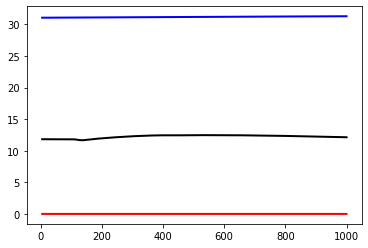

In [ ]:
batch_max = torch.max(target, dim=2)[0].squeeze(1)
batch_min = torch.min(target, dim=2)[0].squeeze(1)
batch_mean = torch.mean(target2, dim=2).squeeze(1)
batch_max.shape
cut_off = 0
channel = 0
plt.plot(lid_v[cut_off:], batch_max[cut_off:,...,channel], label='max', color='blue', linewidth=2)
plt.plot(lid_v[cut_off:], batch_min[cut_off:,...,channel], label='min', color='red', linewidth=2)
plt.plot(lid_v[cut_off:], batch_mean[cut_off:,...,channel], label='mmeanax', color='black', linewidth=2)
plt.show

In [ ]:
batch_max = torch.max(target, dim=2)[0].squeeze(1)
batch_min = torch.min(target, dim=2)[0].squeeze(1)
batch_mean = torch.mean(target2, dim=2).squeeze(1)
batch_max.shape
cut_off = 0
channel = 0
plt.plot(lid_v[cut_off:], batch_max[cut_off:,...,channel], label='max', color='blue', linewidth=2)
plt.plot(lid_v[cut_off:], batch_min[cut_off:,...,channel], label='min', color='red', linewidth=2)
plt.plot(lid_v[cut_off:], batch_mean[cut_off:,...,channel], label='mmeanax', color='black', linewidth=2)
plt.show

Torch FVM solutions

In [5]:
dir = r'C:\Users\Noahc\Documents\USYD\tutorial\cavity_sparse\case.foam' # works with branch 8b84c8c3920ded25156e8da0475b22fc2a2253bf
#dir = r'C:\Users\Noahc\Documents\USYD\tutorial\cavity_128_simple_from_GNOT\case.foam' 
mesh, vtk_mesh, U_gt =  load_case_mesh(dir, bc_dict)

ERROR:root:Number of cells/points in mesh and field do not match: mesh = 65536, field = 1024 in U
ERROR:root:Number of cells/points in mesh and field do not match: mesh = 65536, field = 1024 in UEqn
ERROR:root:Number of cells/points in mesh and field do not match: mesh = 65536, field = 1024 in divU
ERROR:root:Number of cells/points in mesh and field do not match: mesh = 65536, field = 1024 in divU_phiAll
ERROR:root:Number of cells/points in mesh and field do not match: mesh = 65536, field = 1024 in grad(U)
ERROR:root:Number of cells/points in mesh and field do not match: mesh = 65536, field = 1024 in grad(p)
ERROR:root:Number of cells/points in mesh and field do not match: mesh = 65536, field = 1024 in lapU
ERROR:root:Number of cells/points in mesh and field do not match: mesh = 65536, field = 1024 in p
ERROR:root:Number of cells/points in mesh and field do not match: mesh = 65536, field = 1024 in U
ERROR:root:Number of cells/points in mesh and field do not match: mesh = 65536, field =

Calculating face centers and areas for 262656 faces
{'max_non_orthogonality': 0.0, 'avg_non_orthogonality': 0.0, 'max_skewness': 1.9073777366429567e-05, 'avg_skewness': 2.521129090382601e-06}
 Found Patch "movingWall" with 256 Faces
 Found Patch "fixedWalls" with 768 Faces
Boundary faces indexed: 1024/132096 patches found
Calculating Cell2Cell at Face Linear Interpolation Weights (L2):
  min w:0.5000,               max w:0.5000,               mean w:0.5000
Error fetching U from mesh, setting to None


In [47]:
p_gt = torch.tensor(vtk_mesh['p'], dtype = dtype).unsqueeze(0).unsqueeze(0).unsqueeze(-1)
print(p_gt.shape)

torch.Size([1, 1, 1024, 1])


In [48]:
_, gradp_pred = Divergence_Operator.caclulate(mesh, field=p_gt, field_type='p')
divU_pred, gradU_pred = Divergence_Operator.caclulate(mesh, field=U_gt)
lap_pred = Laplacian_Operator.caclulate(mesh, field=U_gt)*nu

Sample solutions

In [49]:
gradU_gt = torch.tensor(vtk_mesh['grad(U)'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
lapU_gt = torch.tensor(vtk_mesh['lapU'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
divU_gt = torch.tensor(vtk_mesh['divU_phiAll'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
divU_corrected_gt = torch.tensor(vtk_mesh['divU'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
gradP_gt = torch.tensor(vtk_mesh['grad(p)'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)

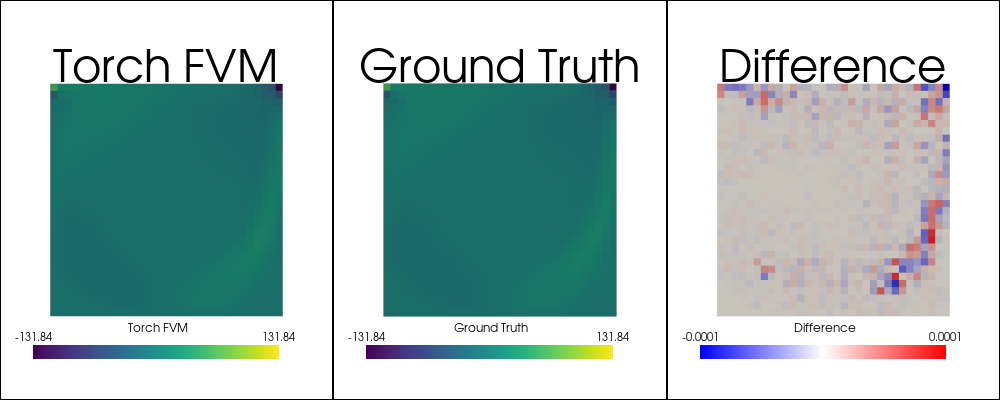

In [50]:
names = ['dudx', 'dudy', 'dvdx', 'dvdy']
#for i, j in enumerate([0,1,3,4]):
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=gradU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = gradU_gt.squeeze(0).squeeze(0).numpy(),
                    clims3=[-0.0001, 0.0001]
                    )

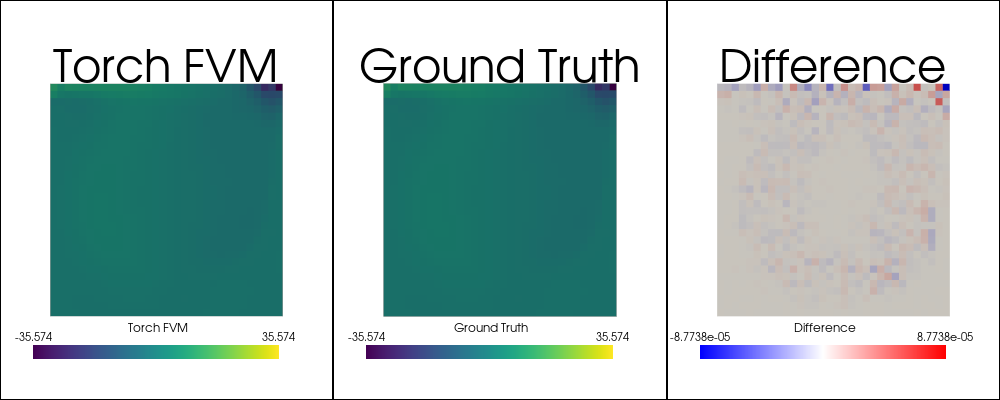

In [70]:
names = ['divU', 'divV']
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=divU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = divU_gt.squeeze(0).squeeze(0).numpy(),
                    )

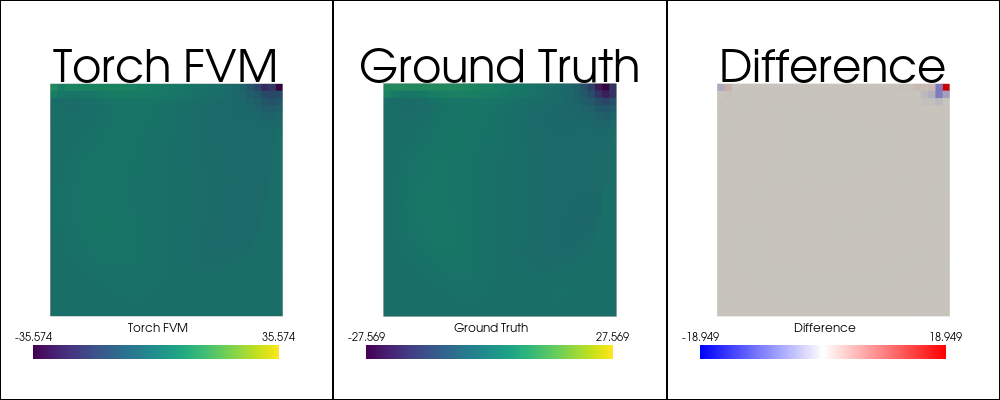

In [52]:
names = ['divU', 'divV']
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=divU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = divU_corrected_gt.squeeze(0).squeeze(0).numpy(),
                    )

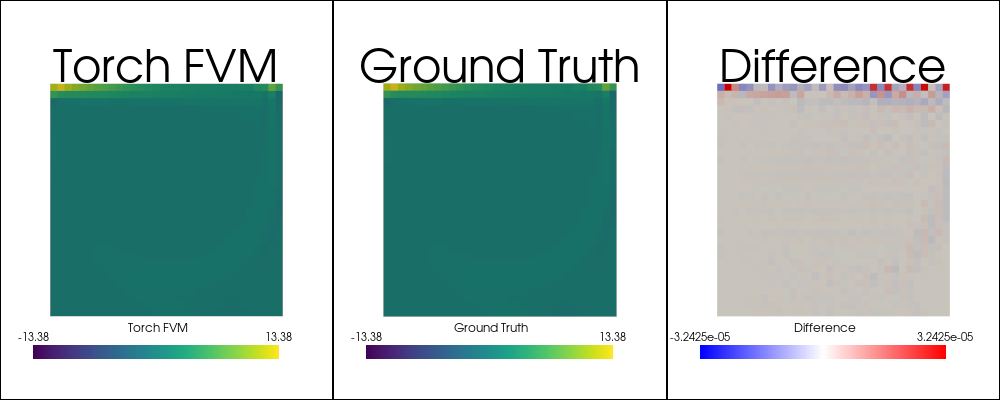

In [84]:
names = ['lapU', 'lapV']
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=lap_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = lapU_gt.squeeze(0).squeeze(0).numpy(),
                    #clims3=[-0.000001, 0.000001]
                    )

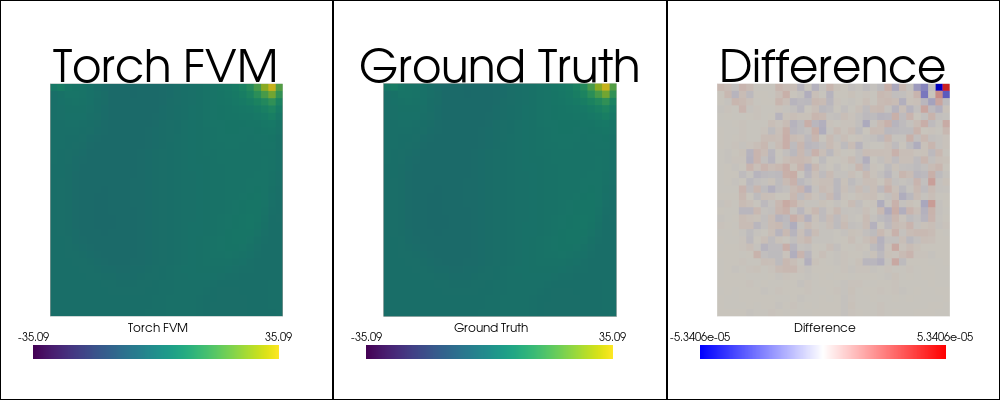

In [54]:
names = ['px', 'py']
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=gradp_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = gradP_gt.squeeze(0).squeeze(0).numpy(),
                    )

### Momentum Equations

In [55]:
print(divU_corrected_gt.shape, lapU_gt.shape, gradP_gt.shape)

torch.Size([1, 1, 1024, 3]) torch.Size([1, 1, 1024, 3]) torch.Size([1, 1, 1024, 3])


In [71]:
max_1 = torch.argmin(divU_pred[...,0])
max_2 = torch.argmin(divU_pred[...,1])
max_3 = torch.argmin(divU_pred[...,2])
print(divU_gt[0,0,max_1,:])
print(divU_gt[0,0,max_2,:])
print(divU_gt[0,0,max_3,:])

tensor([-35.5736,  -6.0869,   0.0000])
tensor([-14.3799, -28.4564,   0.0000])
tensor([0.0002, 0.0002, 0.0000])


In [74]:
print(divU_gt[...,max_1,:])
print(lapU_gt[...,max_1,:])
print(gradP_gt[...,max_1,:])
print(mom_gt1[...,max_1,:])

tensor([[[-35.5736,  -6.0869,   0.0000]]])
tensor([[[5.3024, 2.0345, 0.0000]]])
tensor([[[19.0493, 18.3438,  0.0000]]])
tensor([[[-21.8267,  10.2224,   0.0000]]])


In [85]:
max_4 = torch.argmax(mom_gt1[...,0])
print(mom_gt1[0,0,max_4,:])

tensor([ 6.9282, -6.6915,  0.0000])


In [56]:
gradU_gt
lapU_gt 

mom_gt1 = divU_gt - lapU_gt + gradP_gt
mom_gt2 = divU_corrected_gt - lapU_gt + gradP_gt

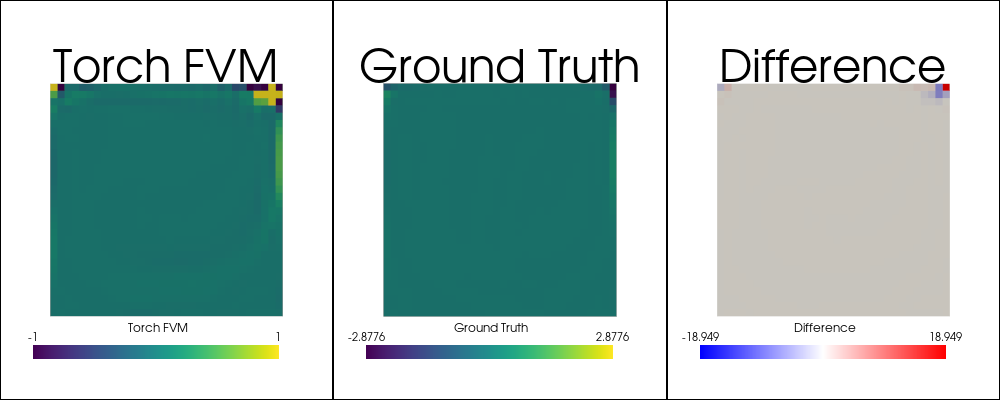

In [86]:
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=mom_gt1.squeeze(0).squeeze(0).numpy(),
                    ground_truth = mom_gt2.squeeze(0).squeeze(0).numpy(),
                    clims=[-1,1]
                    )

In [22]:
mom_gt1.shape

torch.Size([1, 1, 1024, 3])

In [91]:
h = 1.0 / (32 - 1.0) # this is technically dx or dy

# lets try this:
#h = 1

all_norms = torch.log1p((mom_gt1)**2)
#all_norms = (mom_gt1)**2
all_norms = torch.log((mom_gt1)**2)

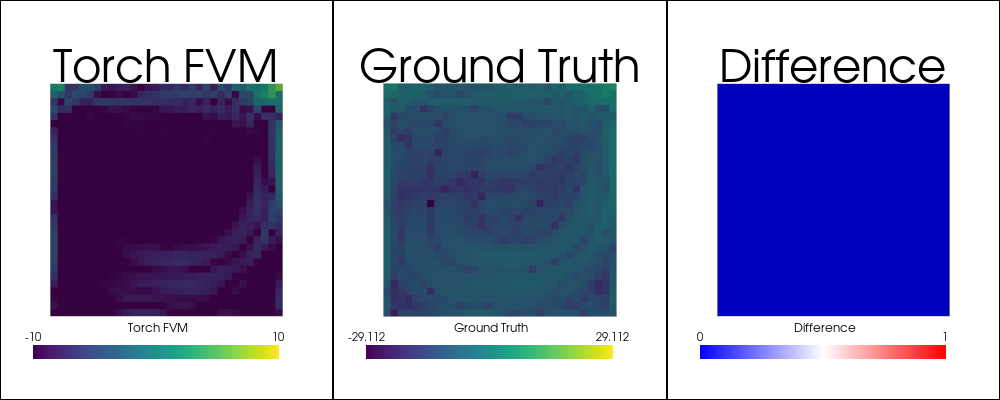

In [95]:
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=all_norms.squeeze(0).squeeze(0).unsqueeze(-1).numpy(),
                    ground_truth = all_norms.squeeze(0).squeeze(0).unsqueeze(-1).numpy(),
                    clims=[-10,10]
                    )

In [29]:
all_norms.shape

torch.Size([1, 1, 1024])

## Cylinder Case

In [ ]:
from src.utils.data_utils import get_bc_dict # default cylinder bc list

dir = r'C:\Users\Noahc\Downloads\c5_test\case.foam'
mesh, vtk_mesh, U_gt =  load_case_mesh(dir, bc_dict=get_bc_dict())
nu = 0.013333333333333334

In [ ]:
divU_pred, gradU_pred = Divergence_Operator.caclulate(mesh, field=U_gt)

mesh._calculate_correction_vectors(method = mesh.correction_method)
lap_pred = Laplacian_Operator.caclulate(mesh, 
                                        field=U_gt, 
                                        correction_method=None)*nu
lap_pred_corrected = Laplacian_Operator.caclulate(mesh, field=U_gt, 
                                                  correction_method=mesh.correction_method,
                                                  gradient_field=gradU_pred
                                                  )*nu

In [ ]:
gradU_gt = torch.tensor(vtk_mesh['grad(U)'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
divU_gt = torch.tensor(vtk_mesh['divU'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
lapU_gt = torch.tensor(vtk_mesh['lapU'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
lapU_gt_corrected = torch.tensor(vtk_mesh['lapU_corrected'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)

In [ ]:
names = ['dudx', 'dudy', 'dvdx', 'dvdy']
#for i, j in enumerate([0,1,3,4]):
for i, j in enumerate([0,1]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=gradU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = gradU_gt.squeeze(0).squeeze(0).numpy(),
                    zoom=False
                    )

Note OpenFoam performs a pressure correction loop over phi (as seen below).

In [ ]:
names = ['divU', 'divV']
for i, j in enumerate([0,1]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=divU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = divU_gt.squeeze(0).squeeze(0).numpy(),
                    )

In [ ]:
divU_gt_uncorrected = torch.tensor(vtk_mesh['divU_phiAll'], dtype = torch.float32).unsqueeze(0).unsqueeze(0)
names = ['divU', 'divV']
for i, j in enumerate([0,1]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=divU_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = divU_gt_uncorrected.squeeze(0).squeeze(0).numpy(),
                    )

### Laplacian

Laplacian has two methods of calculation, corrected and uncorrected. Both methods use the under-relaxed vector discretization.

In [ ]:
names = ['lapU', 'lapV']
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=lap_pred.squeeze(0).squeeze(0).numpy(),
                    ground_truth = lapU_gt.squeeze(0).squeeze(0).numpy(),
                    zoom=True
                    )

In [ ]:
names = ['lapU', 'lapV']
for i, j in enumerate([0]):
    plot_comparison(vtk_mesh, None, f'Uncorrected_{names[i]}',i=j, interactive = True, point_label=False,
                    prediction=lap_pred_corrected.squeeze(0).squeeze(0).numpy(),
                    ground_truth = lapU_gt_corrected.squeeze(0).squeeze(0).numpy(),
                    zoom=True
                    )

### Pressure Gradient

In [ ]:
p = torch.tensor(Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\p'), dtype=dtype).unsqueeze(0).unsqueeze(0).unsqueeze(-1)
grad_p = Ofpp.parse_internal_field(r'C:\Users\Noahc\Downloads\c5_test\30.3\grad(p)')

In [ ]:
class Divergence_Operator():
    
    @staticmethod
    def caclulate(self, field: torch.Tensor, field_type:str = 'U') -> torch.Tensor:
        batch_size = field.shape[0]
        time_size = field.shape[1]
        channel_size = field.shape[-1]

        div_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, self.mesh.dim), dtype=field.dtype, device=self.device)
        grad_field = torch.zeros((batch_size, time_size, self.mesh.n_cells, self.mesh.dim, channel_size), dtype=field.dtype, device=self.device)
        
        div_field, grad_field = Divergence_Operator.internal_flux(self, div_field, grad_field, field)
        div_field, grad_field = Divergence_Operator.boundary_flux(self, div_field, grad_field, field, field_type)
        div_field/= self.mesh.cell_volumes.reshape(1,1,-1,1)
        grad_field/= self.mesh.cell_volumes.reshape(1,1,-1,1,1)
        return div_field, grad_field.flatten(start_dim=-2)

    def internal_flux(self, div_field:torch.tensor, grad_field:torch.tensor, field:torch.tensor) -> torch.Tensor:
        face_values = interpolate_to_faces(self, field)
        idx = self.mesh.internal_faces
        divergence = torch.einsum('btfd,fd->btf', face_values, self.mesh.face_areas[idx]).unsqueeze(-1) * face_values
        gradient = torch.einsum('btfd,fe->btfed', face_values, self.mesh.face_areas[idx])
        print(face_values.shape, gradient.shape, grad_field.shape)
        div_field.index_add_(2, self.mesh.face_owners[idx], divergence)
        div_field.index_add_(2, self.mesh.face_neighbors[idx], -divergence)
        print(gradient.shape, grad_field.shape)
        grad_field.index_add_(2, self.mesh.face_owners[idx], gradient)
        grad_field.index_add_(2, self.mesh.face_neighbors[idx], -gradient)
        return div_field, grad_field
    
    @staticmethod
    def boundary_flux(self, div_field:torch.tensor, grad_field:torch.tensor, field:torch.tensor, field_type:str='U') -> torch.Tensor:
        batch_size = field.shape[0]
        time_size = field.shape[1]
        channel_size = field.shape[-1]

        for patch_name, patch_faces in self.mesh.patch_face_keys.items():
            patch_type = self.bc_conditions[field_type][patch_name]['type']
            
            if patch_type in ('empty','noSlip'):
                continue
            if patch_type == 'fixedValue':
                field_value = torch.tensor(self.bc_conditions[field_type][patch_name]['value'], dtype=self.dtype, device=self.device)
                face_values = field_value.reshape(1, 1, 1, -1).repeat(batch_size, time_size, len(patch_faces), 1)
            elif patch_type == 'symmetryPlane':
                face_values = field[...,self.mesh.face_owners[patch_faces],:] - 2*(torch.einsum('btfc,fc->btf', 
                                                                                                field[...,self.mesh.face_owners[patch_faces],:], 
                                                                                                self.mesh.face_normal_unit_vectors[patch_faces,:]
                                                                                                )).unsqueeze(-1) * self.mesh.face_normal_unit_vectors[patch_faces,:].unsqueeze(0)
            elif patch_type == 'zeroGradient':
                face_values = field[...,self.mesh.face_owners[patch_faces],:]
            else:
                raise NotImplementedError(f'patch type {patch_type} not implemented')
            
            divergence = torch.einsum('btfd,fd->btf', face_values, self.mesh.face_areas[patch_faces]).unsqueeze(-1) * face_values
            gradient = torch.einsum('btfd,fe->btfed', face_values, self.mesh.face_areas[patch_faces])
            
            if patch_type == 'symmetryPlane' and channel_size ==1:  # i.e. Scalar
                gradient = torch.zeros(batch_size, time_size, len(patch_faces), 1, dtype=self.dtype)

            div_field.index_add_(2, self.mesh.face_owners[patch_faces], divergence)
            grad_field.index_add_(2, self.mesh.face_owners[patch_faces], gradient)
    
        return div_field, grad_field

In [ ]:
_, gradient_p = Divergence_Operator.caclulate(mesh, p, field_type='p')

In [ ]:
plot_comparison(vtk_mesh, None, f'None',i=1, interactive = True, point_label=False,
                    prediction=gradient_p[0,0,...].numpy(),
                    ground_truth = grad_p,
                    clims3=[-0.00001,0.00001],
                    zoom=False
                    )